In [129]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import time
import datetime
import math 
import QuantLib as ql
from scipy.optimize import minimize

data = "SPX"

df = pd.DataFrame()

eonia_rates = pd.read_csv(r'eonia.csv', sep=";")

def date_pd_to_ql(date):
    date = pd.to_datetime(date)
    day = date.day
    month = date.month
    year = date.year

    return ql.Date(day, month, year)

current_time = current_price = ATM_price = None
if data == "NASDAQ":
    df = pd.read_csv(r'Nasdaq_optionChain_100821_1915.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df["IV"] = df["IV"]/100
    df["IV (P)"] = df["IV (P)"]/100

    # Remove strikes from Dataframe
    fltr = [140., 145., 150., 155., 160., 165., 170., 175., 180., 185., 190., 195., 200., 210., 220.]
    df = df[df['Strike'].isin(fltr)]

    current_time = pd.Timestamp(year=2021, month=8, day=10, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 188.68
    ATM_price = 190.

elif data == "SPX":
    df = pd.read_csv(r'spx_SABR.csv')
    df['Date'] = pd.to_datetime(df['Date'], format='%y%m%d')

    # Remove IV=0 strikes from Dataframe
    fltr = df[df["IV"] <= 0.]["Strike"].unique()
    df = df[~df['Strike'].isin(fltr)]
    df = df[~(df['Strike'] <= 3000)]

    current_time = pd.Timestamp(year=2021, month=8, day=3, hour=12)
    today = date_pd_to_ql(current_time)
    current_price = 4300.
    ATM_price = 4300.

elif data == "eurusd":
    df = pd.read_csv(r'eurusd.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

    # Remove strikes from Dataframe
    fltr = [116, 116.5, 117, 117.5, 118, 118.5, 119, 119.5, 120, 120.5, 121]
    df = df[df['Strike'].isin(fltr)]

    current_time = pd.Timestamp(year=2021, month=8, day=24, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 118.90
    ATM_price = 119.00

elif data == "eurostoxx":
    df = pd.read_csv(r'eurostoxx.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%y')

    # Remove strikes from Dataframe
    fltr = np.arange(3950., 4350., 50)
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=30, hour=18)
    today = date_pd_to_ql(current_time)
    current_price = 4035.
    ATM_price = 4050.

elif data == "ftse100":
    df = pd.read_csv(r'ftse100.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%y')

    # Remove strikes from Dataframe
    fltr = np.arange(3950., 4350., 50)
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=28, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 4196.
    ATM_price = 4200.

elif data == "nasdaq100":
    df = pd.read_csv(r'nasdaq100.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y')

    # Remove strikes from Dataframe
    fltr = np.arange(15400., 15850., 50)
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=30, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 15605.
    ATM_price = 15600.

elif data == "nasdaq":
    df = pd.read_csv(r'nasdaq.csv', sep=";")
    df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y')

    # Remove strikes from Dataframe
    fltr = np.arange(11000., 18000., 200) 
    df = df[df['Strike'].isin(fltr)]
    df["IV"] = df["IV"] / 100

    current_time = pd.Timestamp(year=2021, month=8, day=30, hour=19)
    today = date_pd_to_ql(current_time)
    current_price = 15605.
    ATM_price = 15600.

maturities = df["Date"].unique()
strikes = df["Strike"].unique()

ql.Settings.instance().evaluationDate = today
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

spot_quote = ql.QuoteHandle(ql.SimpleQuote(current_price))
rate = ql.SimpleQuote(-0.00482)
riskFreeCurve = ql.FlatForward(today, ql.QuoteHandle(rate), ql.Actual365Fixed())
flat_ts = ql.YieldTermStructureHandle(riskFreeCurve)
dividend_ts = ql.YieldTermStructureHandle(riskFreeCurve)

vols = [np.array(df[df["Date"] == maturities[m]]["IV"]) for m in range(len(maturities))]

plot_size = (12, 5)

dates = [date_pd_to_ql(d) for d in maturities]

Tenors  Spot Rate
0    0.25     -0.575
1    1.00     -0.557
2    3.00     -0.549
3    6.00     -0.529
4   12.00     -0.494

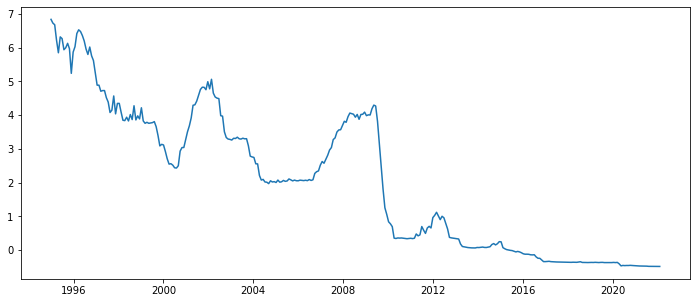

In [130]:
# Spot rates table and chart (EONIA)

rates = [-0.575, -0.557, -0.549, -0.529, -0.494]
tenors = [.25, 1, 3, 6, 12]

spot_rates = pd.DataFrame({"Tenors": tenors, "Spot Rate": rates})
spot_rates.set_index('Tenors')

display(spot_rates)

fig = plt.figure(figsize=(12,5))
eonia_dates = [datetime.date(1994, 12, 31) + datetime.timedelta(days=30*n) for n in range(len(eonia_rates['value']))]
plt.plot(eonia_dates, eonia_rates['value'])
# plt.title("EONIA Rates (%) 1996-2021")

In [131]:
#Plot volatility Surface
def plot_vol_surface(vol_surface, plot_years=np.arange(0.1, (dates[-1] - today) / 365., 0.1), plot_strikes=strikes, funct='blackVol', title="", size=plot_size):
    if type(vol_surface) != list:
        surfaces = [vol_surface]
    else:
        surfaces = vol_surface

    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    ax.set_title(title)
    X, Y = np.meshgrid(plot_strikes, plot_years)

    for surface in surfaces:
        method_to_call = getattr(surface, funct)

        Z = np.array([method_to_call(float(y), float(x)) 
                      for xr, yr in zip(X, Y) 
                          for x, y in zip(xr,yr) ]
                     ).reshape(len(X), len(X[0]))

        surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, linewidth=0.3)

def plot_smile(date, smiles, bounds=None, market=True, title="", size=(15, 4)):

    market_vols = vols[dates.index(date)]

    fig, ax = plt.subplots(figsize=size)
    for smile in smiles:
        ax.plot(strikes, smile[0], label=smile[1])
    if market:
        ax.plot(strikes, market_vols, "rX", label="Actual")
        ax.plot([ATM_price], market_vols[strikes.tolist().index(ATM_price)], "o", label="ATM")
    
    if bounds:
        ax.set_xbound(bounds[0], bounds[1])
        
    ax.set_title(title)
    ax.set_xlabel("Strikes", size=12)
    ax.set_ylabel("Vols", size=12)
    legend = ax.legend(loc="upper right")

# Plot Volatility Smile Comparisons

def smiles_comparison(models, heston_models=[], points=(.2, .4, .6, .8, 1)):
        for i in [round((len(dates)-1) * x) for x in points]:
                tenor = dates[i]
                l = [([model.vol_surface.blackVol(tenor, s) for s in strikes], model.label) for model in models]
                if len(heston_models) > 0:
                        l.extend([([x.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston" ) for x in heston_models])

                plot_smile(tenor, l, title="Volatility Smile for options expiring on {}".format(tenor))


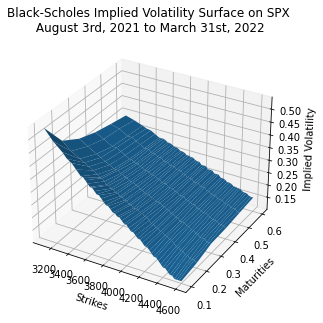

In [132]:
# BLACK VOLATILITY SURFACE

volMatrix = ql.Matrix(len(strikes), len(dates))

for i in range(len(vols)):
    for j in range(len(vols[i])):
        volMatrix[j][i] = vols[i][j]

black_var_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, volMatrix, day_count)
black_var_surface.enableExtrapolation()

title = "Black-Scholes Implied Volatility Surface on {}\n {} to {}".format(data, today, dates[-1])
plot_vol_surface(vol_surface=black_var_surface, plot_strikes=strikes, funct='blackVol', title=title)

In [133]:
#CALIBRATE SABR VOLATILITY SURFACE

class SABRSmile:
    def __init__(self, date, shift=0, beta=1, method="normal", fwd=current_price, zero_rho=False):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = vols[dates.index(self.date)]
        self.shift = shift
        self.fwd = fwd
        self.forward_price = self.fwd * math.exp(rate.value() * self.expiryTime)
        self.zero_rho = zero_rho
        self.alpha, self.beta, self.nu, self.rho = (.1, beta, 0., 0. if self.zero_rho else .1)
        self.method = method
        self.newVols = None
        self.error = None

    def initialize(self):
        # alpha, beta, nu, rho
        cons = (
        {'type': 'ineq', 'fun': lambda x: x[0] - 0.001},
        {'type': 'eq', 'fun': lambda x: x[1] - self.beta},
        {'type': 'ineq', 'fun': lambda x: x[2] - 0.001},
        {'type': 'ineq', 'fun': lambda x: .99 - x[3]**2},
        )

        x = self.set_init_conds()

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        [self.alpha, self.beta, self.nu, self.rho] = result['x']
    
        self.newVols = [self.vols_by_method(strike, self.alpha, self.beta, self.nu, self.rho) for strike in strikes]

    def set_init_conds (self):
        return [self.alpha, self.beta, self.nu, self.rho]

    def vols_by_method(self, strike, alpha, beta, nu, rho):
        if self.method == "floch-kennedy":
            return ql.sabrFlochKennedyVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)
        elif self.shift != 0:
            return ql.shiftedSabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho, self.shift)
        else:
            return ql.sabrVolatility(strike, self.forward_price, self.expiryTime, alpha, beta, nu, rho)

    def f(self, params):

        alpha, beta, nu, rho = params

        beta = self.beta
        alpha = max(alpha, 1e-8) # Avoid alpha going negative
        nu = max(nu, 1e-8) # Avoid nu going negative
        rho = max(rho, -0.999) if self.zero_rho==False else 0.0 # Avoid rhp going < -1.0 or set zero correlation
        rho = min(rho, 0.999) # Avoid rho going > 1.0

        vols = np.array([self.vols_by_method(strike, alpha, beta, nu, rho) for strike in strikes])

        self.error = ((vols - np.array(self.marketVols))**2 ).mean() **.5

        return self.error


class SABRVolatilitySurface:
    def __init__(self, method="normal", beta=1, shift=0, fwd=current_price, label="", zero_rho=False):
        self.method = method
        self._beta = beta
        self.shift = shift
        self.fwd = fwd
        self.label = label
        self.zero_rho = zero_rho

        self.initialize()

    def initialize(self):
        self.vol_surface_vector, self.errors, self.smiles, self.alpha, self.beta, self.nu, self.rho = [], [], [], [], [], [], []
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (ql.Matrix(len(strikes), len(dates)), ql.Matrix(len(strikes), len(dates)))
        
        for i, d in enumerate(dates):
            volSABR = SABRSmile(date=d, beta=self._beta, shift=self.shift, method=self.method, fwd=self.fwd, zero_rho=self.zero_rho)
            volSABR.initialize()

            self.alpha.append(volSABR.alpha)
            self.beta.append(volSABR.beta)
            self.nu.append(volSABR.nu)
            self.rho.append(volSABR.rho)
            
            self.errors.append(volSABR.error)

            smile = volSABR.newVols

            self.vol_surface_vector.extend(smile)
            self.smiles.append(volSABR)

            #constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]
            
            self.vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_data(self):
        d = {'alpha': self.alpha, 'beta': self.beta, 'nu': self.nu, 'rho': self.rho}
        return pd.DataFrame(data=d, index=dates)


# Backbone modelling for SABR
def SABR_backbone_plot (beta=1, bounds=None, shift=0, fixes=(.95, 1, 1.14, 1.24), tenor=dates[2]):
    l = []
    for i in fixes:
        vol_surface = SABRVolatilitySurface(method="normal", shift=current_price*shift, beta=beta, fwd=current_price * i)
        SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, vol_surface.SABRVolMatrix, day_count)
        SABR_vol_surface.enableExtrapolation()

        l.append( ([SABR_vol_surface.blackVol(tenor, s) for s in strikes], "fwd = {}".format(current_price * i) ) )
        
    plot_smile(tenor, l, bounds=bounds, market=False, title="backbone, beta = {}, {}".format(vol_surface.beta[0], tenor))

alpha  beta     nu       rho
August 6th, 2021      0.837724   1.0  0.001  0.099915
August 9th, 2021      0.455540   1.0  0.001  0.100482
August 11th, 2021     0.417029   1.0  0.001  0.099896
August 13th, 2021     0.375678   1.0  0.001  0.100193
August 16th, 2021     0.343826   1.0  0.001  0.099942
August 20th, 2021     0.343833   1.0  0.001  0.100269
August 23rd, 2021     0.298426   1.0  0.001  0.099909
August 25th, 2021     0.295281   1.0  0.001  0.099693
August 27th, 2021     0.296061   1.0  0.001  0.100201
September 10th, 2021  0.267785   1.0  0.001  0.099833
September 17th, 2021  0.260513   1.0  0.001  0.099857
September 24th, 2021  0.260296   1.0  0.001  0.099983
September 30th, 2021  0.255597   1.0  0.001  0.100016
October 15th, 2021    0.251292   1.0  0.001  0.099939
October 29th, 2021    0.249151   1.0  0.001  0.099968
November 19th, 2021   0.244880   1.0  0.001  0.099881
November 30th, 2021   0.241165   1.0  0.001  0.099988
December 17th, 2021   0.240772   1.0  0.001  0.099981
January 31st, 2022    0.239383   1.0  0.001  0.099958
March 31st, 2022      0.236813   1.0  0.001  0.100021

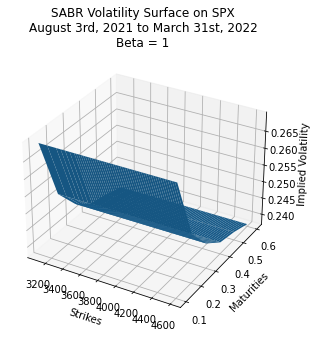

In [134]:
#SABR VOLATILITY SURFACE

volatility_surface = SABRVolatilitySurface()
SABRVolMatrix = volatility_surface.SABRVolMatrix

SABR_vol_surface = ql.BlackVarianceSurface(today, calendar, dates, strikes, SABRVolMatrix, day_count)
SABR_vol_surface.enableExtrapolation()

title = "SABR Volatility Surface on {}\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface(vol_surface=SABR_vol_surface, title=title)

volatility_surface.to_data()

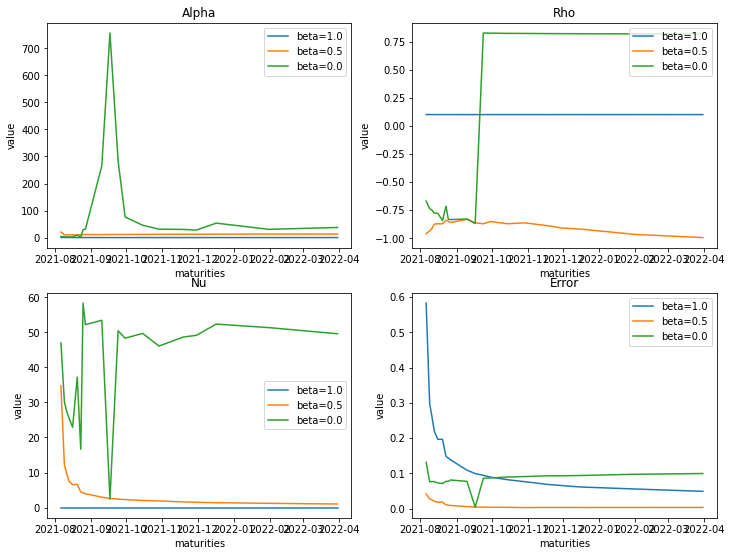

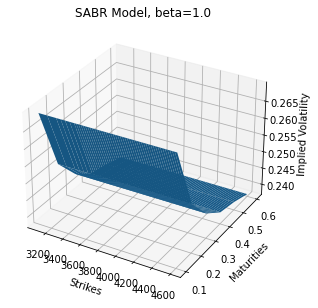

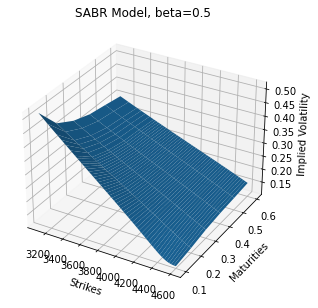

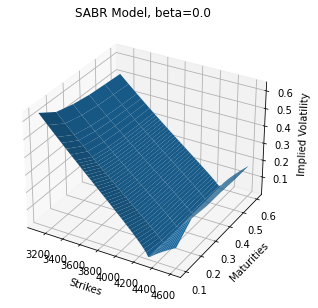

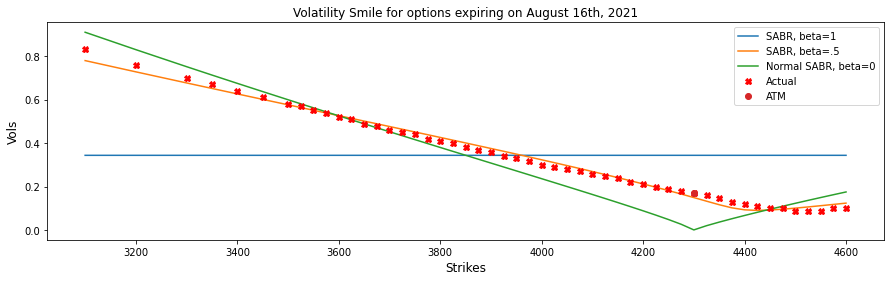

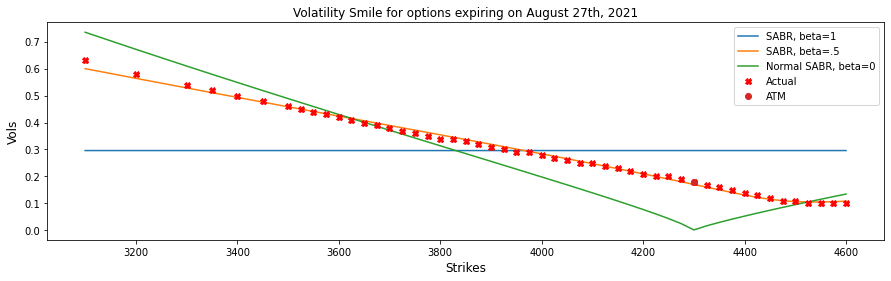

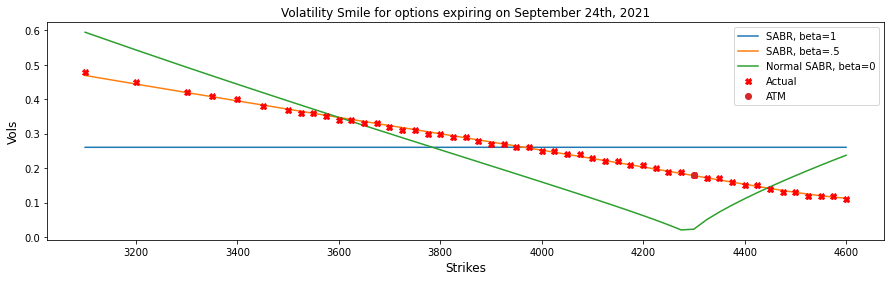

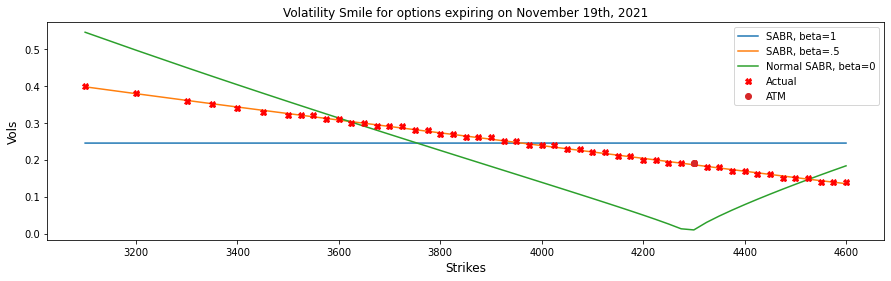

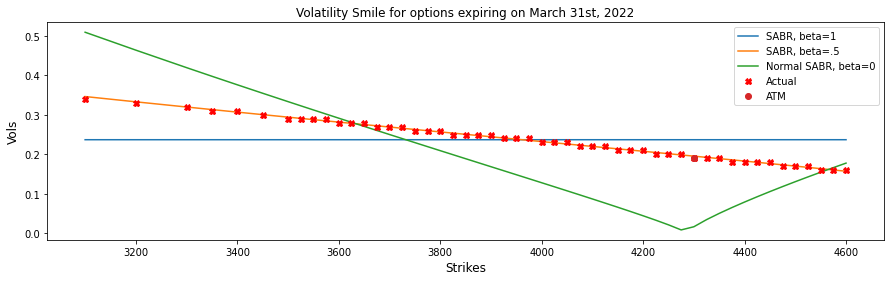

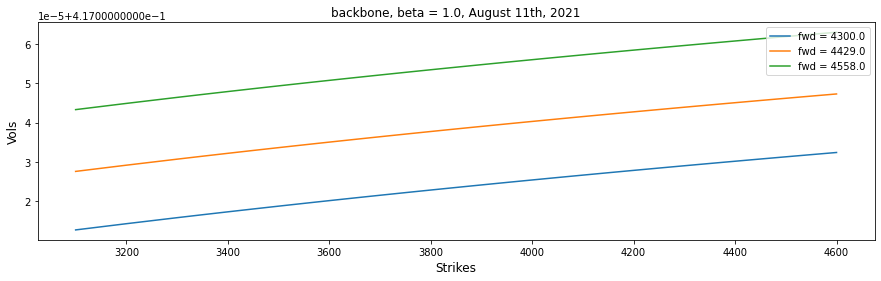

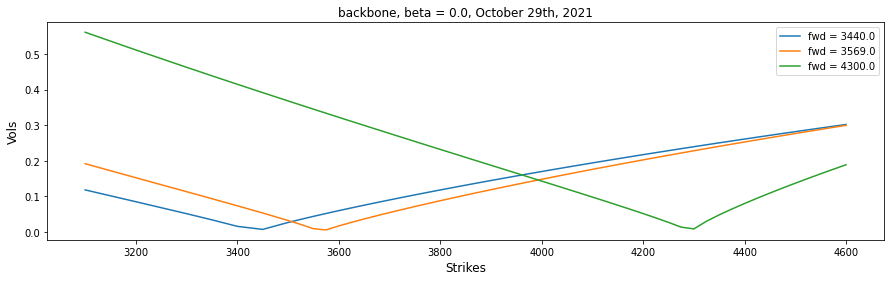

In [135]:
# SABR Volatility model

SABR_beta1 = SABRVolatilitySurface(beta=1, shift=0, label="SABR, beta=1")
SABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, label="SABR, beta=.5")
SABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, label="Normal SABR, beta=0")

def SABRComparison(methods, title=""):
    fig, axs = plt.subplots(2, 2, figsize=plot_size)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=1.5, wspace=None, hspace=None)
    for method in methods:
        lbl = "beta={}".format(method.beta[1])
        axs[0, 0].plot(maturities, method.alpha, label=lbl)
        axs[0, 0].set_title('Alpha')
        axs[0, 0].set(xlabel='maturities', ylabel='value')
        axs[0, 0].legend()
        axs[1, 0].plot(maturities, method.nu, label=lbl)
        axs[1, 0].set_title('Nu')
        axs[1, 0].set(xlabel='maturities', ylabel='value')
        axs[1, 0].legend()
        axs[0, 1].plot(maturities, method.rho, label=lbl)
        axs[0, 1].set_title('Rho')
        axs[0, 1].set(xlabel='maturities', ylabel='value')
        axs[0, 1].legend()
        axs[1, 1].plot(maturities, method.errors, label=lbl)
        axs[1, 1].set_title('Error')
        axs[1, 1].set(xlabel='maturities', ylabel='value')
        axs[1, 1].legend()
        
        method_df = method.to_data()
        display(method_df.style.set_caption("SABR, {}".format(lbl)))

        plot_vol_surface(method.vol_surface, title="{}, {}".format(title, lbl))

    smiles_comparison(methods)

        
SABRComparison([SABR_beta1, SABR_beta5, SABR_beta0], title="SABR Model")

# SABR Backbone modelling
fix = None
if data == "NASDAQ":
    fix = (1, 1.2, 1.3) 
elif data=="SPX":
    fix = (1, 1.03, 1.06)
else: 
    fix = (1, 1.1, 1.2)
b = (current_price*.95, current_price*1.07) if data == "SPX" else (strikes[0], strikes[-1])
SABR_backbone_plot(fixes = fix, )
SABR_backbone_plot(beta=0, fixes = (.8, .83, 1), tenor = dates[-6])

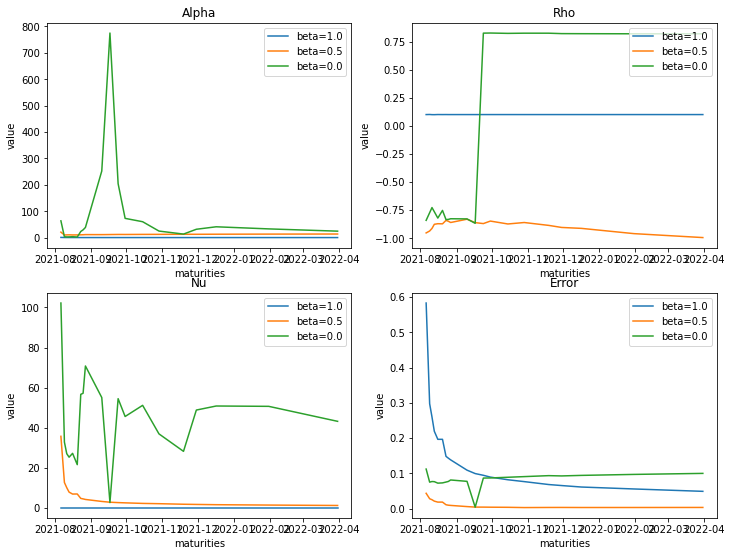

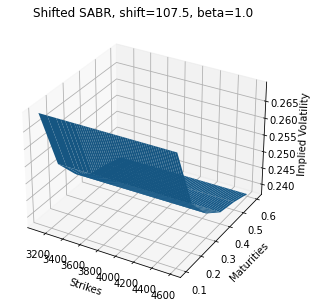

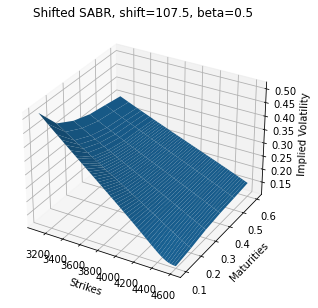

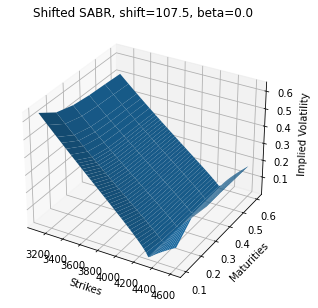

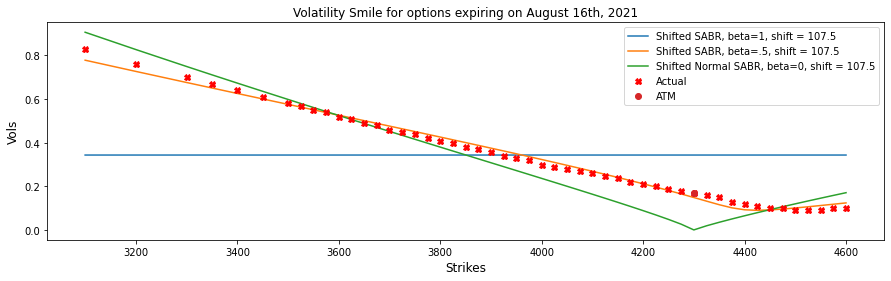

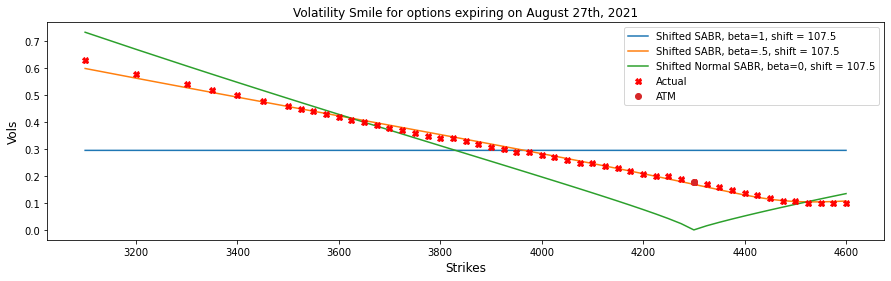

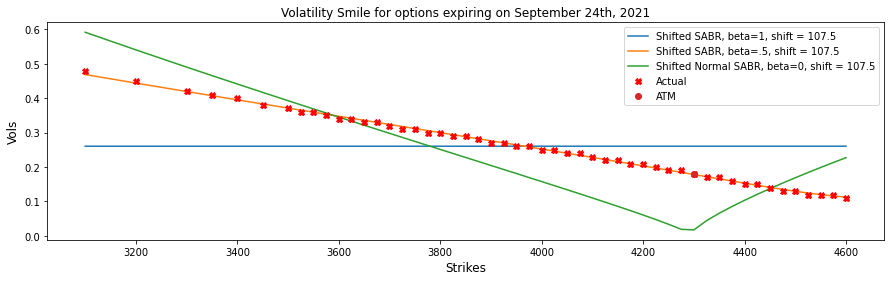

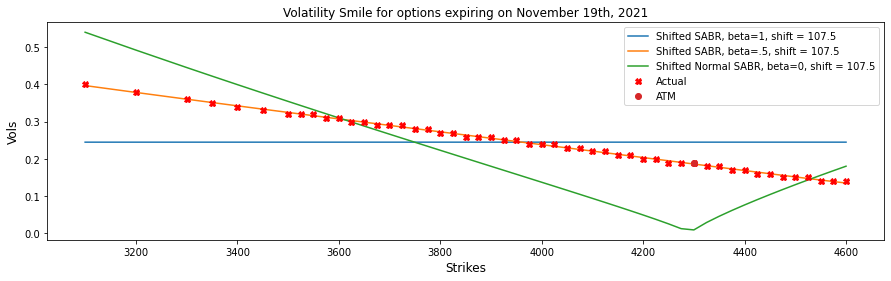

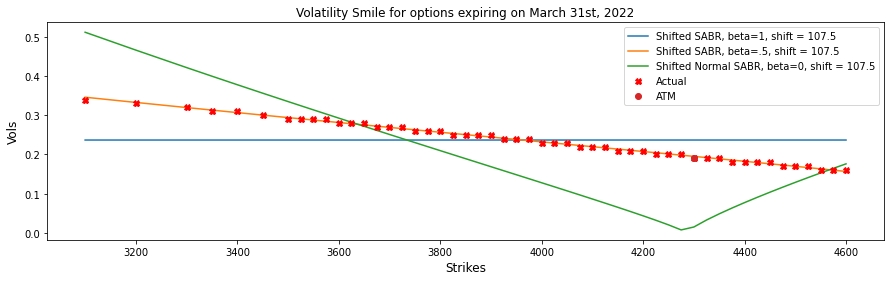

In [136]:
# Shifted SABR Volatility model
shft = .025 * current_price
shiftedSABR_beta1 = SABRVolatilitySurface(beta=1, shift=shft, label="Shifted SABR, beta=1, shift = {}".format(round(shft, 4)))
shiftedSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=shft, label="Shifted SABR, beta=.5, shift = {}".format(round(shft, 4)))
shiftedSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=shft, label="Shifted Normal SABR, beta=0, shift = {}".format(round(shft, 4)))

SABRComparison([shiftedSABR_beta1, shiftedSABR_beta5, shiftedSABR_beta0], title="Shifted SABR, shift={}".format(round(shft, 4)))

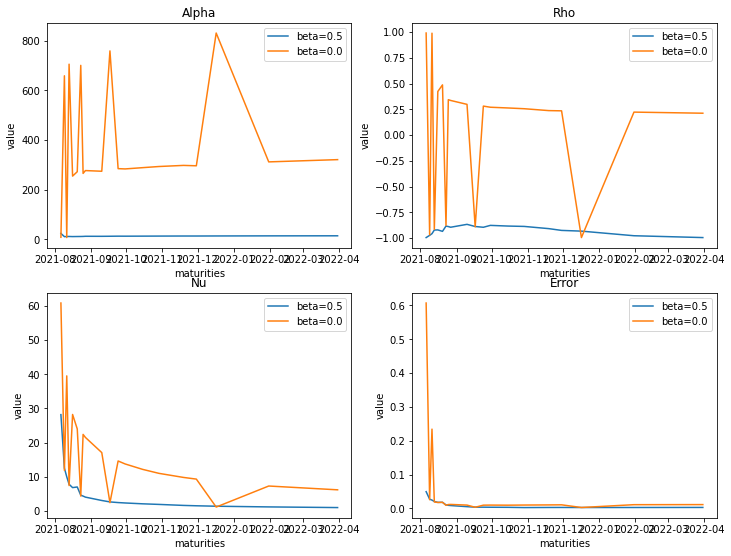

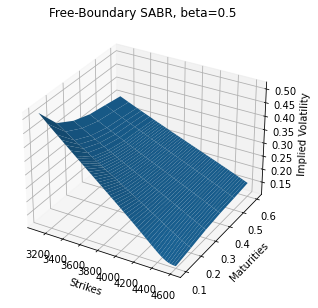

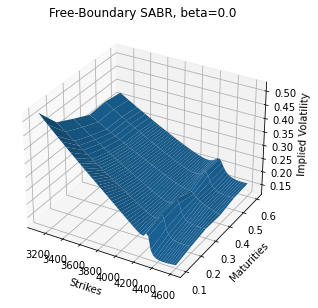

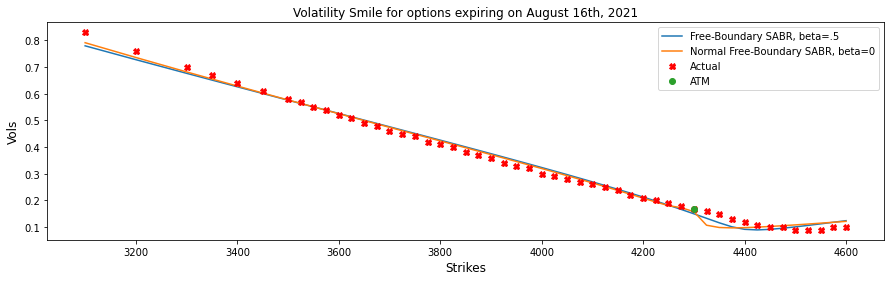

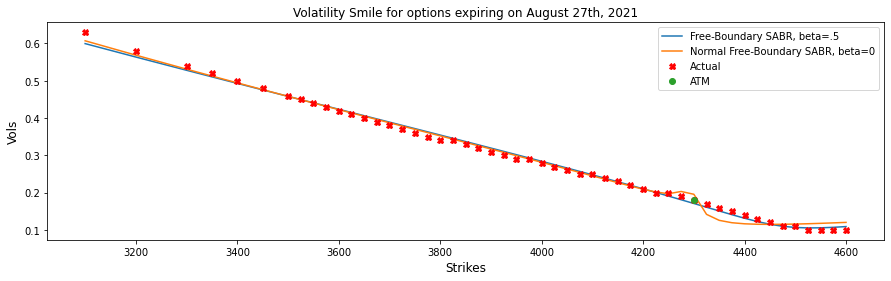

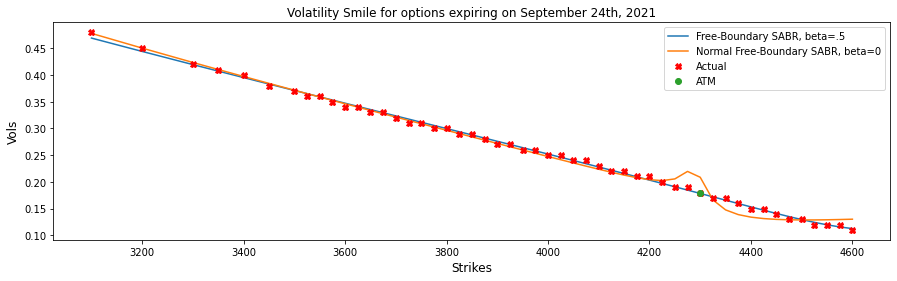

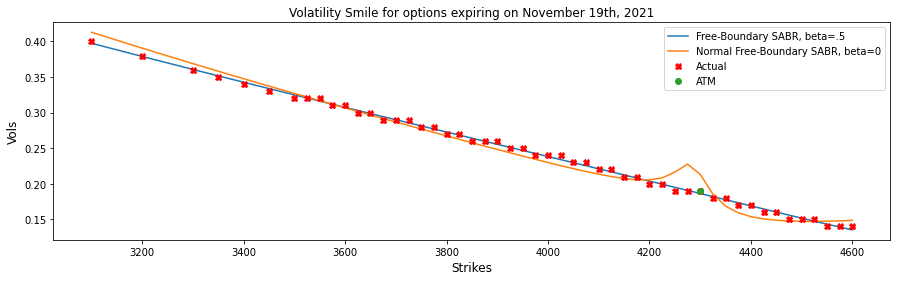

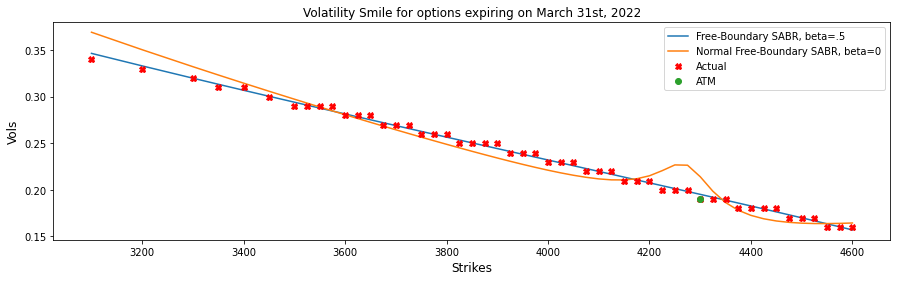

In [137]:
# Free-Boundary SABR Volatility model

freeSABR_beta5 = SABRVolatilitySurface(beta=.5, shift=0, method="floch-kennedy", label="Free-Boundary SABR, beta=.5")
freeSABR_beta0 = SABRVolatilitySurface(beta=.0, shift=0, method="floch-kennedy", label="Normal Free-Boundary SABR, beta=0")

SABRComparison([freeSABR_beta5, freeSABR_beta0], title="Free-Boundary SABR")

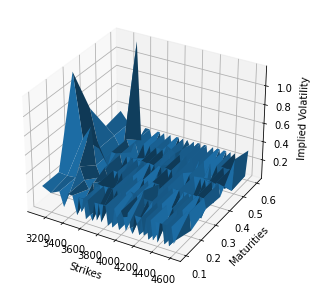

In [138]:
#DUPIRE LOCAL VOLATILITY SURFACE (NOT PLOTTABLE)

black_var_surface.setInterpolation("bicubic")
local_vol_handle = ql.BlackVolTermStructureHandle(black_var_surface)
#if does not work use NoExceptLocalVolSurface
# local_vol_surface = ql.LocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote)
local_vol_surface = ql.NoExceptLocalVolSurface(local_vol_handle, flat_ts, dividend_ts, spot_quote, .25)

# Plot the Dupire surface ...
local_vol_surface.enableExtrapolation()
plot_vol_surface(local_vol_surface, funct='localVol')


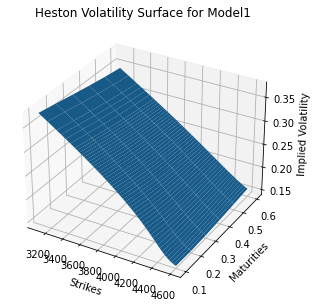

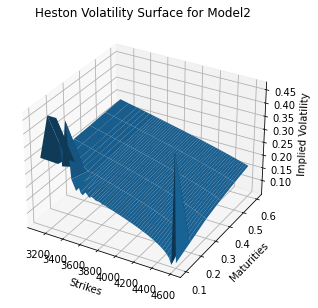

In [139]:
#HESTON MODEL SURFACE PLOTTING (Levenberg-Marquardt Method)

class hestonModelSurface:
    def __init__(self, params, label=""):
        (self.v0, self.kappa, self.theta, self.sigma, self.rho) = params
        self.label = label
        self.hestonModel = None
        self.engine = None
        self.heston_helpers = None
        self.heston_vol_surface = None
        self.strks = None
        self.marketValue = None
        self.modelValue = None
        self.relativeError = None
        self.avgError = None

        self.initialize()

    def initialize(self):
        process = ql.HestonProcess(flat_ts, dividend_ts, 
                                ql.QuoteHandle(ql.SimpleQuote(current_price)), 
                                self.v0, self.kappa, self.theta, self.sigma, self.rho)
        self.hestonModel = ql.HestonModel(process)
        self.engine = ql.AnalyticHestonEngine(self.hestonModel) 

        self.heston_helpers = []
        black_var_surface.setInterpolation("bicubic")
        one_year_idx = -1 
        date = dates[one_year_idx]

        for j, s in enumerate(strikes):
            t = (date - today)
            p = ql.Period(t, ql.Days)
            sigma = vols[one_year_idx][j]

            helper = ql.HestonModelHelper(p, calendar, current_price, s, 
                                        ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                        flat_ts, 
                                        dividend_ts)
            helper.setPricingEngine(self.engine)
            self.heston_helpers.append(helper)

        lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
        self.hestonModel.calibrate(self.heston_helpers, lm, 
                        ql.EndCriteria(500, 300, 1.0e-8, 1.0e-8, 1.0e-8))
        self.v0, self.kappa, self.theta, self.sigma, self.rho = self.hestonModel.params()

        self.set_surface()
        self.compute_errors()

    def set_surface(self):
        # Boilerplate to get to the Vol Surface object
        heston_handle = ql.HestonModelHandle(self.hestonModel)
        self.heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

    def compute_errors(self):
        # Statistical analysis on the Heston model and plotting

        self.strks, self.marketValue, self.modelValue, self.relativeError = ([], [], [], [])

        self.avgError = 0
        for i, opt in enumerate(self.heston_helpers):
            err = (opt.modelValue()/opt.marketValue() - 1.0)
            self.strks.append(strikes[i]); self.marketValue.append(opt.marketValue())
            self.modelValue.append(opt.modelValue())
            self.relativeError.append(100.0*(opt.modelValue()/opt.marketValue() - 1.0))
            self.avgError += abs(err)
        self.avgError = self.avgError*100.0/len(self.heston_helpers)

        self.to_data()

    def to_data(self):
        self.errors_data = pd.DataFrame({"Strikes": self.strks, "Market Value": self.marketValue, "Model Value": self.modelValue, "Relative Error (%)": self.relativeError})
        self.var_data = pd.DataFrame(data=[self.theta, self.kappa, self.sigma, self.rho, self.v0, self.avgError], index=["theta", "kappa", "sigma", "rho", "v0", "avgError"], columns=["Value"])

m1_params, m2_params = (None, None)

if data == "NASDAQ":
    m1_params = (0.02,0.2,0.5,0.1,0.01)
    m2_params = (0.06,0.3,0.2,0.2,0.02)
elif data == "SPX":
    m1_params = (0.05,0.2,0.5,0.1,0.09)
    m2_params = (0.01,0.5,0.2,0.2,0.06)
elif data == "eurostoxx":
    m1_params = (0.1,0.2,0.2,0.2,0.01)
    m2_params = (0.16,0.4,0.1,0.2,0.01)
elif data == "ftse100":
    m1_params = (0.1,0.2,0.2,0.2,0.01)
    m2_params = (0.16,0.4,0.1,0.2,0.01)
elif data == "nasdaq100":
    m1_params = (0.01,0.1,0.1,0.5,0.03)
    m2_params = (0.03,0.3,0.5,0.3,0.04)
elif data == "nasdaq":
    m1_params = (0.01,0.5,0.5,0.1,0.03)
    m2_params = (0.03,0.3,0.5,0.3,0.04)
elif data == "eurusd":
    m1_params = (0.2,0.5,0.5,0.51,-0.4)
    m2_params = (0.03,0.3,0.5,0.3,0.04)

hestonModel1 = hestonModelSurface(m1_params, label="Model1")
hestonModel2 = hestonModelSurface(m2_params, label="Model2")

plot_vol_surface(hestonModel1.heston_vol_surface, title="Heston Volatility Surface for {}".format(hestonModel1.label))
plot_vol_surface(hestonModel2.heston_vol_surface, title="Heston Volatility Surface for {}".format(hestonModel2.label))

No handles with labels found to put in legend.


No handles with labels found to put in legend.


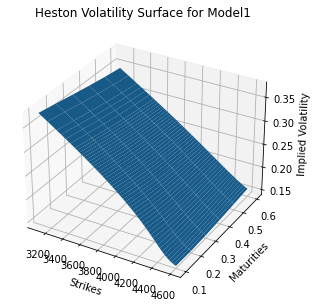

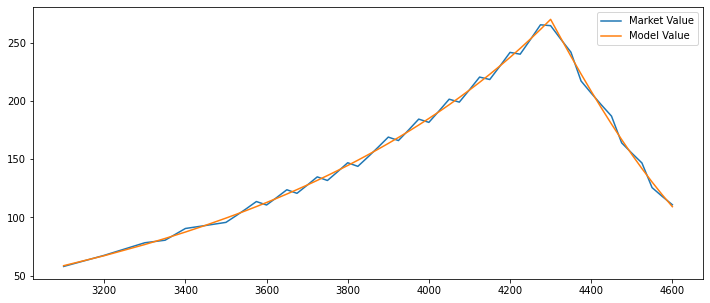

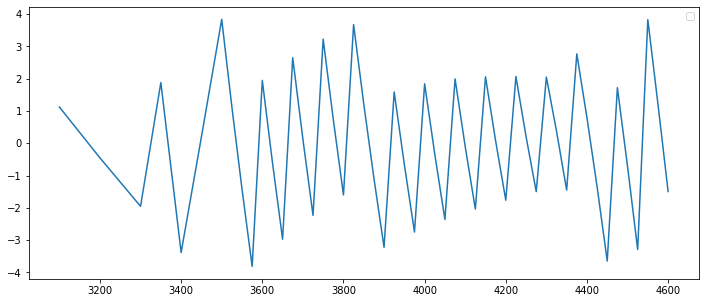

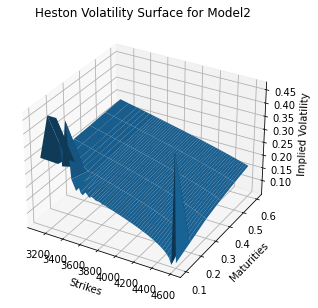

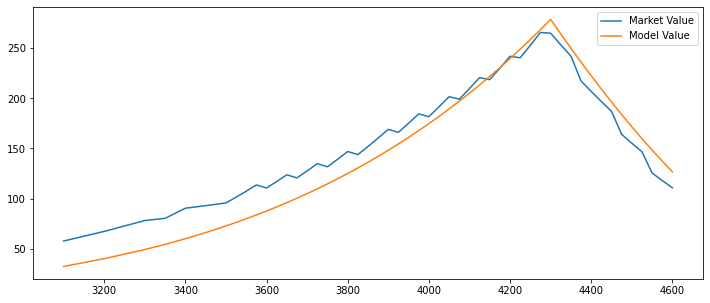

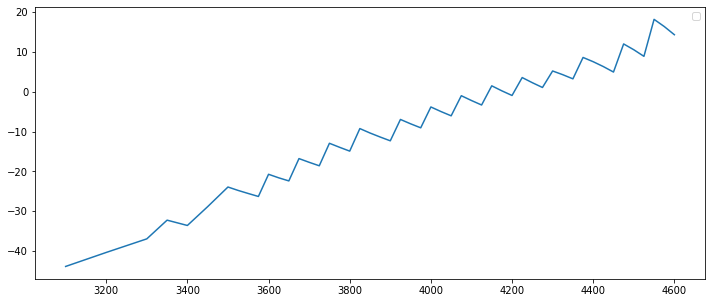

In [140]:
# HESTON Surface Plotting (Model1, Model2)

for model in (hestonModel1, hestonModel2):
    plot_vol_surface(model.heston_vol_surface, title="Heston Volatility Surface for {}".format(model.label))
    display(model.errors_data.style.set_caption("{} calibration results".format(model.label))); display(model.var_data.style.set_caption("{} parameters output".format(model.label)))

    fig1 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.marketValue, label="Market Value")
    plt.plot(model.strks, model.modelValue, label="Model Value")
    plt.title='Model1: Heston surface Market vs Model Value'; plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()
    fig2 = plt.figure(figsize=plot_size)
    plt.plot(model.strks, model.relativeError)
    plt.title='Model1: Heston surface Relative Error (%)'; plt.xlabel='strikes'; plt.ylabel='value'
    plt.legend()

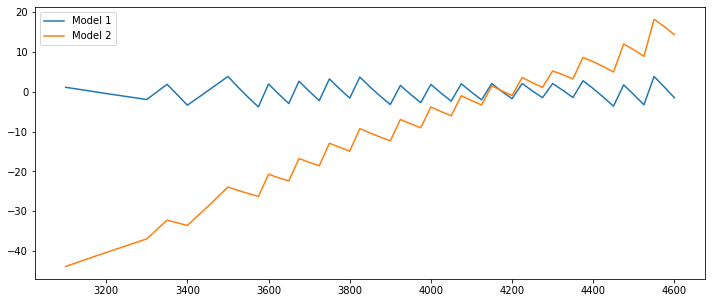

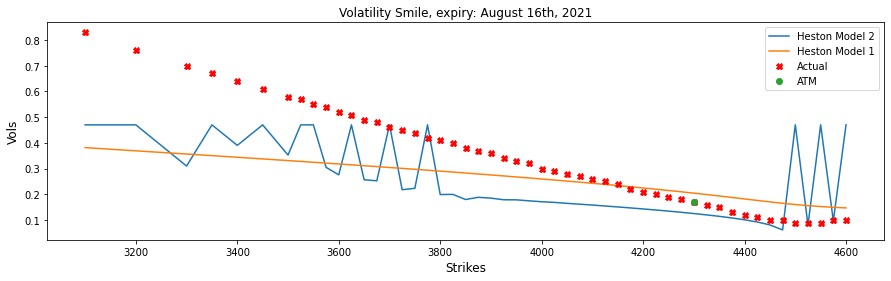

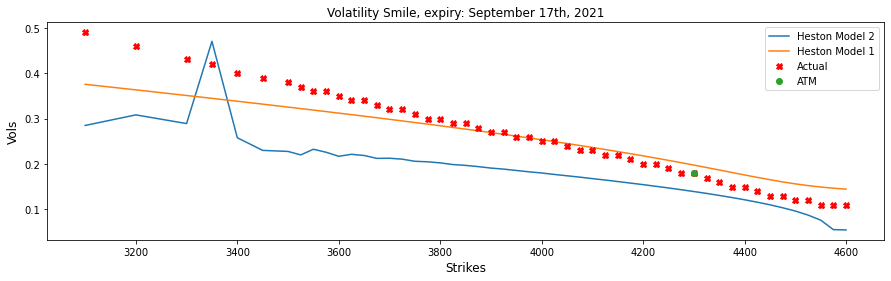

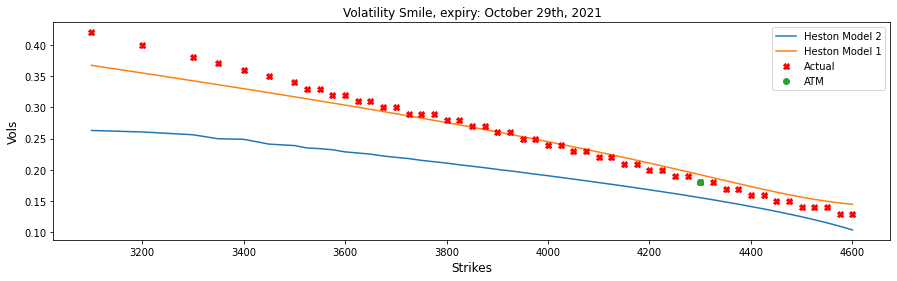

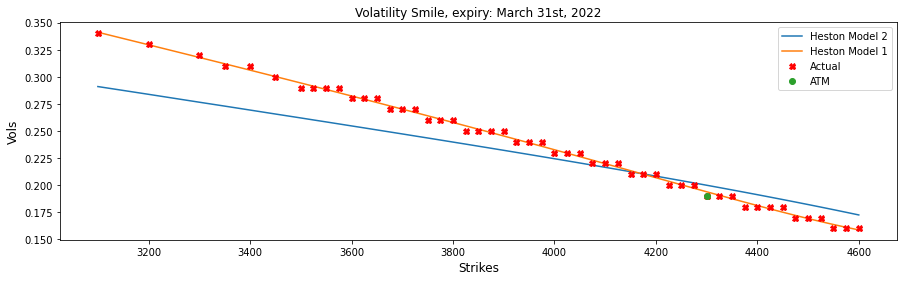

In [141]:
# Relative error comparison
plt.figure(figsize=plot_size)
plt.plot(hestonModel1.strks, hestonModel1.relativeError, label="Model 1")
plt.plot(hestonModel2.strks, hestonModel2.relativeError, label="Model 2")
plt.legend()

# Volatility smiles comparison
tenors = [dates[round((len(dates)-1) * x)] for x in (.2, .5, .75, 1)]
for tenor in tenors:
    l = [
        ([hestonModel2.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 2" ),
        ([hestonModel1.heston_vol_surface.blackVol(tenor, s) for s in strikes], "Heston Model 1" )
        ]
    plot_smile(tenor, l, market=True, title="Volatility Smile, expiry: {}".format(tenor))

alpha_free  beta_free   nu_free  rho_free   alpha_N  \
August 23rd, 2021       6.739762        0.5  8.260400       0.0  6.739762   
August 25th, 2021       6.938356        0.5  7.904156       0.0  6.938356   
August 27th, 2021       7.460862        0.5  7.453753       0.0  7.460862   
September 10th, 2021    8.015386        0.5  5.628950       0.0  8.015386   
September 17th, 2021    8.367409        0.5  5.027431       0.0  8.367409   
September 24th, 2021    8.598474        0.5  4.793146       0.0  8.598474   
September 30th, 2021    8.619202        0.5  4.553980       0.0  8.619202   
October 15th, 2021      8.737576        0.5  4.199702       0.0  8.737576   
October 29th, 2021      8.741055        0.5  4.018323       0.0  8.741055   
November 19th, 2021     9.453499        0.5  3.367701       0.0  9.453499   
November 30th, 2021     9.266997        0.5  3.291683       0.0  9.266997   
December 17th, 2021     9.157506        0.5  3.235239       0.0  9.157506   
January 31st, 2022      8.891313        0.5  3.112134       0.0  8.891313   
March 31st, 2022        8.574347        0.5  2.967914       0.0  8.574347   

                      beta_N       nu_N     rho_N       MSE  
August 23rd, 2021        0.0  16.520800  0.873385  0.080011  
August 25th, 2021        0.0  15.808312  0.878590  0.077782  
August 27th, 2021        0.0  14.907505  0.885564  0.076295  
September 10th, 2021     0.0  11.257900  0.983032  0.063950  
September 17th, 2021     0.0  10.054862  0.990000  0.064613  
September 24th, 2021     0.0   9.586292  0.990000  0.065582  
September 30th, 2021     0.0   9.107960  0.990000  0.067190  
October 15th, 2021       0.0   8.399403  0.990000  0.071873  
October 29th, 2021       0.0   8.036646  0.990000  0.073538  
November 19th, 2021      0.0   6.735402  0.990000  0.097128  
November 30th, 2021      0.0   6.583366  0.990000  0.097605  
December 17th, 2021      0.0   6.470479  0.990000  0.096648  
January 31st, 2022       0.0   6.224268  0.990000  0.095907  
March 31st, 2022         0.0   5.935829  0.990000  0.095521

No handles with labels found to put in legend.


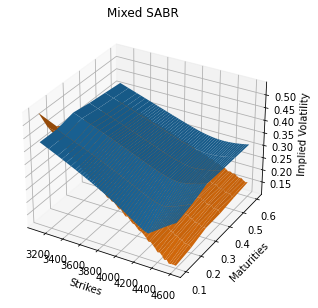

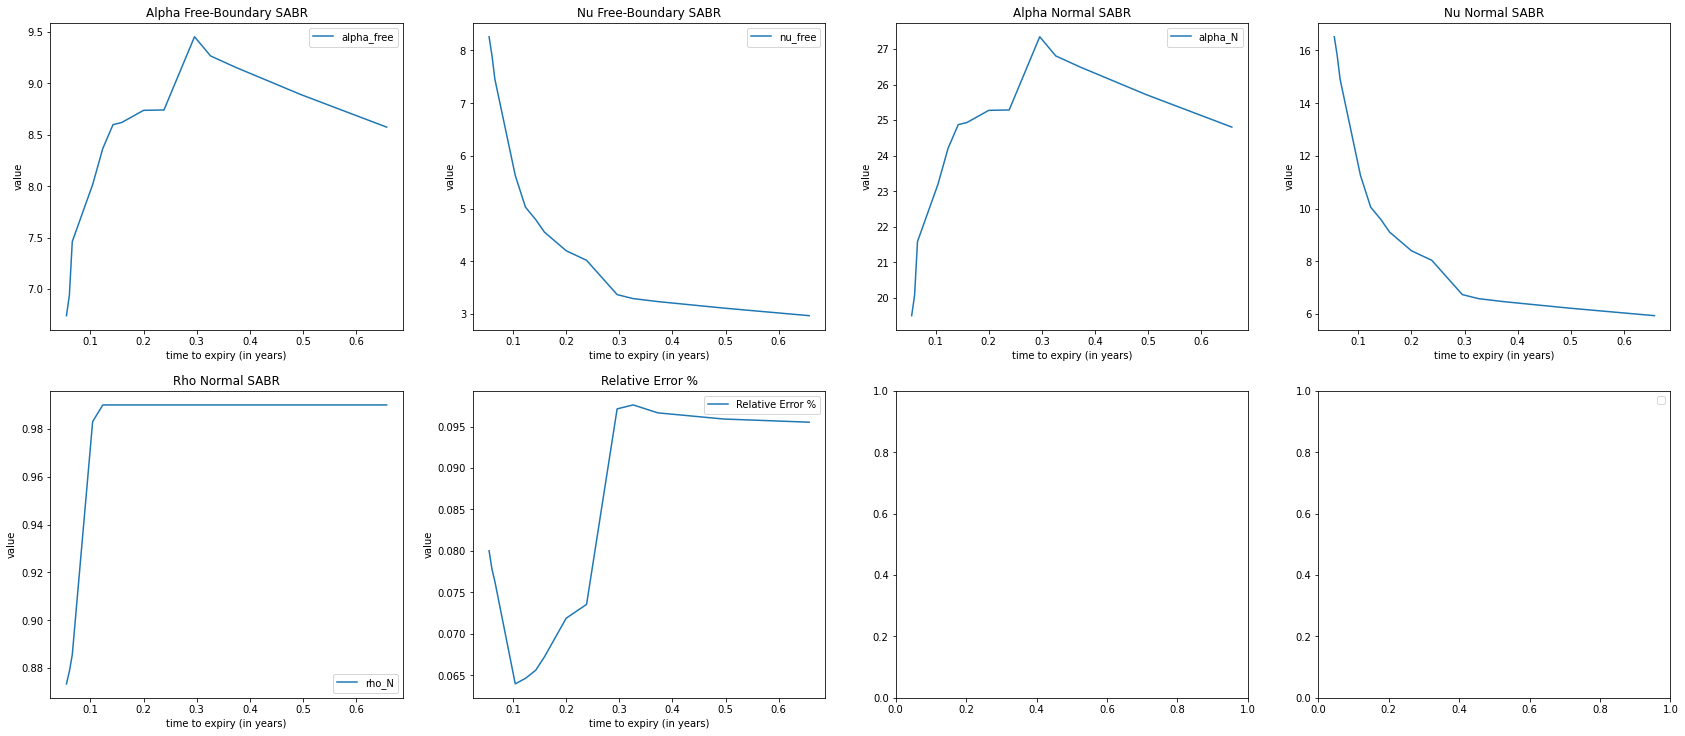

In [142]:
# MIXTURE SABR

class MixtureSABRSmile:
    def __init__(self, date, fwd=current_price, s=0):
        self.date = date
        self.expiryTime = round((self.date - today)/365, 6)
        self.marketVols = vols[dates.index(self.date)]
        self.fwd = fwd
        self.s = s
        self.alpha_N = .1; self.beta_N = 0.; self.nu_N = .1; self.rho_N = .1
        self.alpha_free = .1; self.beta_free = .5; self.nu_free = .1; self.rho_free = 0.
        
        self.initialize()

    def initialize(self):

        # # calibrate the Free Zero-Correlation SABR first
        self.freeSABR = SABRSmile(
            date=self.date, beta=.5, method="floch-kennedy", fwd=self.fwd, zero_rho=True)
        self.freeSABR.initialize()
        self.alpha_free = self.freeSABR.alpha
        self.beta_free = self.freeSABR.beta
        self.nu_free = self.freeSABR.nu

        # alpha, beta, nu, rho (Normal, free)
        cons = (
            {'type': 'eq', 'fun': lambda x: x[0] - self.alpha_free * \
                math.log(current_price)**self.beta_free},
            {'type': 'eq', 'fun': lambda x: x[4] - self.alpha_free},
            {'type': 'eq', 'fun': lambda x: x[1]},
            {'type': 'eq', 'fun': lambda x: x[5] - self.beta_free},
            {'type': 'eq', 'fun': lambda x: x[2] - \
                self.nu_free / (1 - self.beta_free)},
            {'type': 'eq', 'fun': lambda x: x[6] - self.nu_free},
            {'type': 'ineq', 'fun': lambda x: x[3]},
            {'type': 'ineq', 'fun': lambda x: .99 - x[3]},
            {'type': 'eq', 'fun': lambda x: x[7]},
        )

        # Set initial conditions
        x = [self.alpha_N, self.beta_N, self.nu_N, self.rho_N, self.alpha_free, self.beta_free, self.nu_free, self.rho_free]

        result = minimize(self.f, x, constraints=cons, method="SLSQP")
        self.error = result['fun']
        params = [self.alpha_N, self.beta_N, self.nu_N, self.rho_N, self.alpha_free,
                  self.beta_free, self.nu_free, self.rho_free] = result['x']

        self.newVols = [self.calibrate_volatilities(
            strike, params) for strike in strikes]

    def calibrate_volatilities(self, strike, params):

        p = (params[0] * params[5] * math.exp(self.s)) / \
            ((params[0] * params[5] * math.exp(self.s)) + abs(params[2] * params[3]))

        normalSABR = ql.sabrVolatility(
            strike, self.fwd, self.expiryTime, *params[:4])

        return math.sqrt((p**2) * self.freeSABR.newVols[int(np.where(strikes == strike)[0])] + ((1-p)**2) * normalSABR)

    def f(self, params):

        mixed_vols = np.array([self.calibrate_volatilities(
            strike, params) for strike in strikes])

        self.error = ((mixed_vols - np.array(self.marketVols))**2).mean() ** .5

        return self.error


class MixtureSABRVolatilitySurface:
    def __init__(self, fwd=current_price, label="", dates=dates):
        self.fwd = fwd
        self.label = label
        self.dates = dates
        self.vol_surface_vector, self.errors = [], []
        self.alpha_N, self.beta_N, self.nu_N, self.rho_N = [], [], [], []
        self.alpha_free, self.beta_free, self.nu_free, self.rho_free = [], [], [], []

        self.initialize()

    def initialize(self):
        self.SABRVolMatrix, self.SABRVolDiffMatrix = (
            ql.Matrix(len(strikes), len(self.dates)), 
            ql.Matrix(len(strikes), len(self.dates))
            )

        for i, d in enumerate(self.dates):
            volMixedSABR = MixtureSABRSmile(date=d, fwd=self.fwd)

            self.alpha_N.append(volMixedSABR.alpha_N)
            self.alpha_free.append(volMixedSABR.alpha_free)
            self.beta_N.append(volMixedSABR.beta_N)
            self.beta_free.append(volMixedSABR.beta_free)
            self.nu_N.append(volMixedSABR.nu_N)
            self.nu_free.append(volMixedSABR.nu_free)
            self.rho_N.append(volMixedSABR.rho_N)
            self.rho_free.append(volMixedSABR.rho_free)

            self.errors.append(volMixedSABR.error)

            smile = volMixedSABR.newVols
            self.vol_surface_vector.extend(smile)

            # constructing the SABRVolatilityMatrix
            for j in range(len(smile)):
                self.SABRVolMatrix[j][i] = smile[j]
                self.SABRVolDiffMatrix[j][i] = (smile[j] - vols[i][j]) / vols[i][j]

            self.vol_surface = ql.BlackVarianceSurface(
                today, calendar, self.dates, strikes, self.SABRVolMatrix, day_count)
            self.vol_surface.enableExtrapolation()

    def to_data(self):
        d = {'alpha_free': self.alpha_free, 'beta_free': self.beta_free, 'nu_free': self.nu_free, 'rho_free': self.rho_free,
             'alpha_N': self.alpha_free, 'beta_N': self.beta_N, 'nu_N': self.nu_N, 'rho_N': self.rho_N,
             'MSE': self.errors,
             }
        return pd.DataFrame(data=d, index=self.dates)

    def plot(self):
        fig, axs = plt.subplots(2, 4, figsize=plot_size)
        plt.subplots_adjust(right=2, top=2)

        x_values = [(x-today)/365. for x in self.dates]

        axs[0, 0].plot(x_values, self.alpha_free, label="alpha_free")
        axs[0, 0].set_title('Alpha Free-Boundary SABR')
        axs[0, 0].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 0].legend()
        axs[0, 1].plot(x_values, self.nu_free, label="nu_free")
        axs[0, 1].set_title('Nu Free-Boundary SABR')
        axs[0, 1].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 1].legend()
        axs[0, 2].plot(x_values, self.alpha_N, label="alpha_N")
        axs[0, 2].set_title('Alpha Normal SABR')
        axs[0, 2].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[0, 2].legend()
        axs[0, 3].plot(x_values, self.nu_N, label="nu_N")
        axs[0, 3].set_title('Nu Normal SABR')
        axs[0, 3].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 3].legend()
        axs[1, 0].plot(x_values, self.rho_N, label="rho_N")
        axs[1, 0].set_title('Rho Normal SABR')
        axs[1, 0].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 0].legend()
        axs[1, 1].plot(x_values, self.errors, label="Relative Error %")
        axs[1, 1].set_title('Relative Error %')
        axs[1, 1].set(xlabel='time to expiry (in years)', ylabel='value')
        axs[1, 1].legend()

tenors = dates[6:] if data == "SPX" else dates
mixtureSABR = MixtureSABRVolatilitySurface(dates=tenors, label="Mixed SABR") 
display(mixtureSABR.to_data())
plot_vol_surface([mixtureSABR.vol_surface, black_var_surface], title="Mixed SABR")
mixtureSABR.plot()

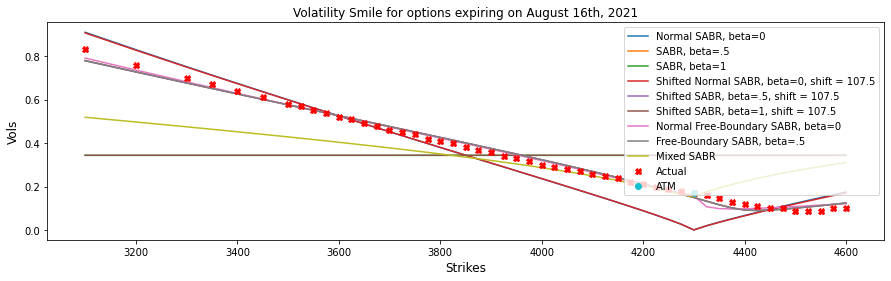

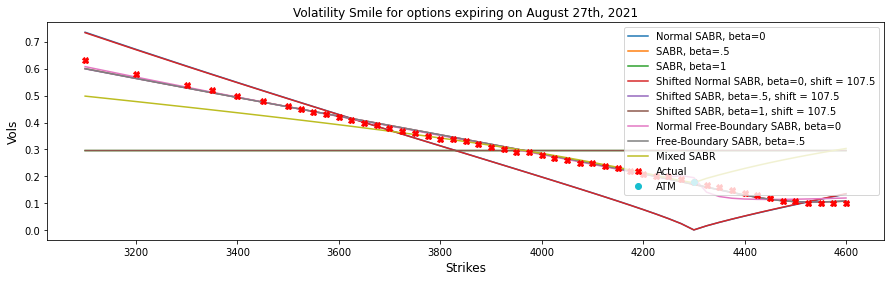

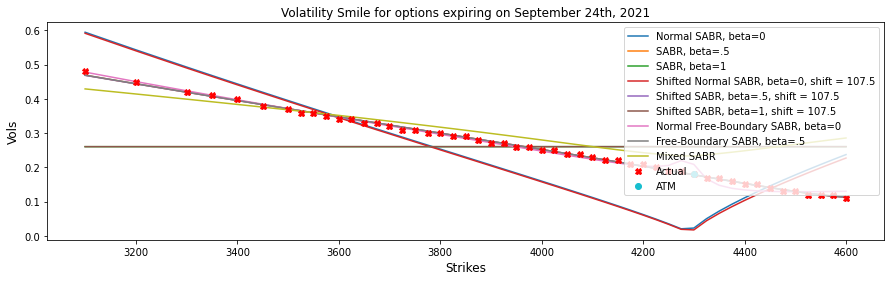

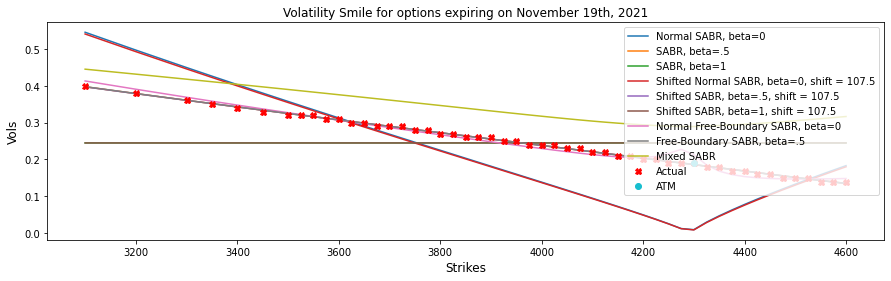

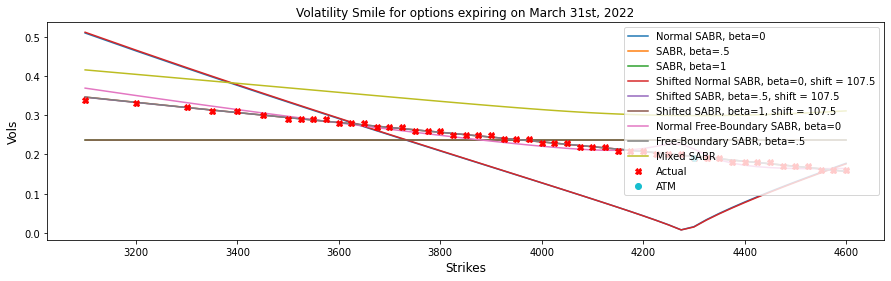

In [143]:
# VOLATILIY SMILES COMPARISON

models = (
        SABR_beta0, SABR_beta5, SABR_beta1, 
        shiftedSABR_beta0, shiftedSABR_beta5, shiftedSABR_beta1,
        freeSABR_beta0, freeSABR_beta5,
        mixtureSABR
        )

smiles_comparison(models)

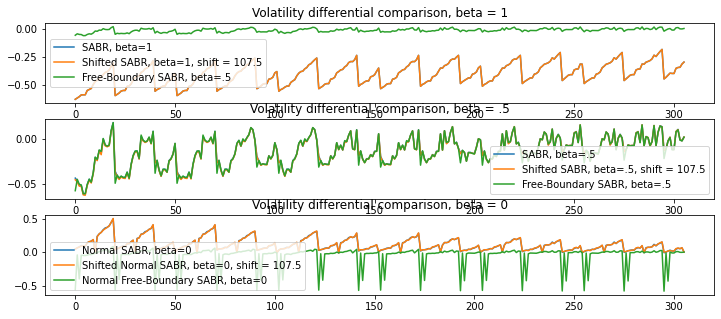

In [144]:
# Volatility differential comparison

def volDiffMatrix(model, part=1.):
    m = []
    for a in range(len(dates)):
        for b in range(len(strikes)):
            m.append(model.SABRVolDiffMatrix[a][b])
    return m [:round((len(m)-1) * part)]

fig, axs = plt.subplots(3, 1, figsize=plot_size)
for model in (SABR_beta1, shiftedSABR_beta1, freeSABR_beta5):
    v = volDiffMatrix(model, .3)
    axs[0].plot(v, label=model.label)
    axs[0].set_title("Volatility differential comparison, beta = 1")
axs[0].legend()

for model in (SABR_beta5, shiftedSABR_beta5, freeSABR_beta5):
    v = volDiffMatrix(model, .3)
    axs[1].plot(v, label=model.label)
    axs[1].set_title("Volatility differential comparison, beta = .5")
axs[1].legend()

for model in (SABR_beta0, shiftedSABR_beta0, freeSABR_beta0):
    v = volDiffMatrix(model, .3)
    axs[2].plot(v, label=model.label)
    axs[2].set_title("Volatility differential comparison, beta = 0")
axs[2].legend()


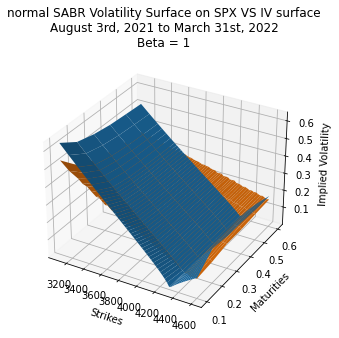

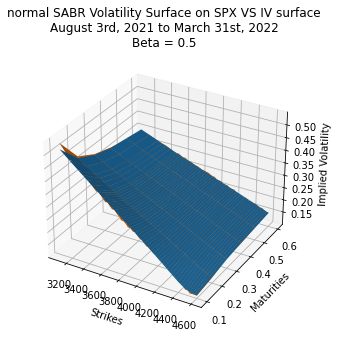

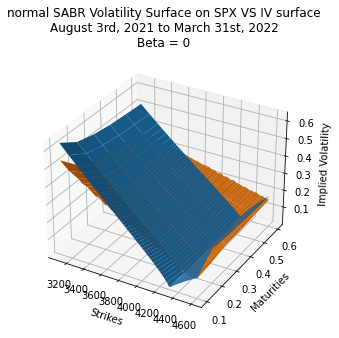

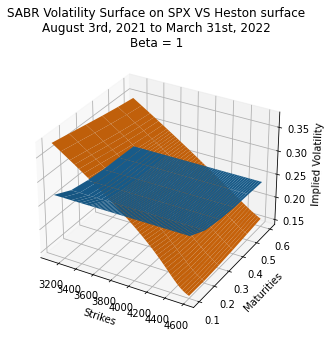

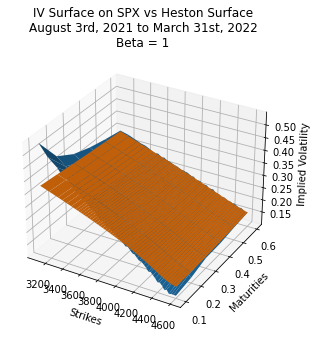

In [145]:
# Volatility Surfaces plots comparison

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0.5".format(data, today, dates[-1])
plot_vol_surface([SABR_beta5.vol_surface, black_var_surface], title=title)

title = "normal SABR Volatility Surface on {} VS IV surface\n{} to {}\nBeta = 0".format(data, today, dates[-1])
plot_vol_surface([SABR_beta0.vol_surface, black_var_surface], title=title)

title = "SABR Volatility Surface on {} VS Heston surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([SABR_beta1.vol_surface, hestonModel1.heston_vol_surface], title=title)

title = "IV Surface on {} vs Heston Surface\n{} to {}\nBeta = 1".format(data, today, dates[-1])
plot_vol_surface([black_var_surface, hestonModel1.heston_vol_surface], title=title)